### IMPORT

In [96]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain 
import folium
import random
import numpy as np
from matplotlib.ticker import ScalarFormatter
import powerlaw
import seaborn as sns

## MANIPOLAZIONE FILES CSV

In [97]:
df = pd.read_csv('./dataset/treni_modificati.csv') 
df_citta = pd.read_csv('./dataset/df_citta.csv')
df_comuni = pd.read_csv('./dataset/comuni_coordinates.csv')

# CREAZIONE TRENI_SOLO_CITTA.CSV (ARCHI)

colonne_da_tenere = ['stazPart', 'stazArr']
df = df[colonne_da_tenere]
#salva
#df.to_csv('./dataset/treni_solo_citta.csv', index=False)

#CREAZIONE CITTA.CSV (NODI)

# Unisci le due colonne in una singola serie e ottieni i valori unici
df = pd.concat([df['stazPart'], df['stazArr']]).unique()
# Salva
#pd.DataFrame(df, columns=['citta_uniche']).to_csv('./dataset/df_citta.csv', index=False)

#AGGIUNGE LOCATION

colonne_da_tenere = ['DENOMINAZIONE_ITA_ALTRA', 'LAT', 'LON']
df_comuni = df_comuni[colonne_da_tenere]
# Salva 
#df_comuni.to_csv('./dataset/df_comuni.csv', index=False)

# rinomina la colonna per aiutarci in seguito
df_comuni.rename(columns={'DENOMINAZIONE_ITA_ALTRA': 'citta_uniche'}, inplace=True) 
merged_data = pd.merge(df_citta, df_comuni, on='citta_uniche', how='inner') # Merge
# Salva
#pd.DataFrame(merged_data).to_csv('./dataset/merged_data.csv', index=False)


## GRAFO E MISURAZIONI

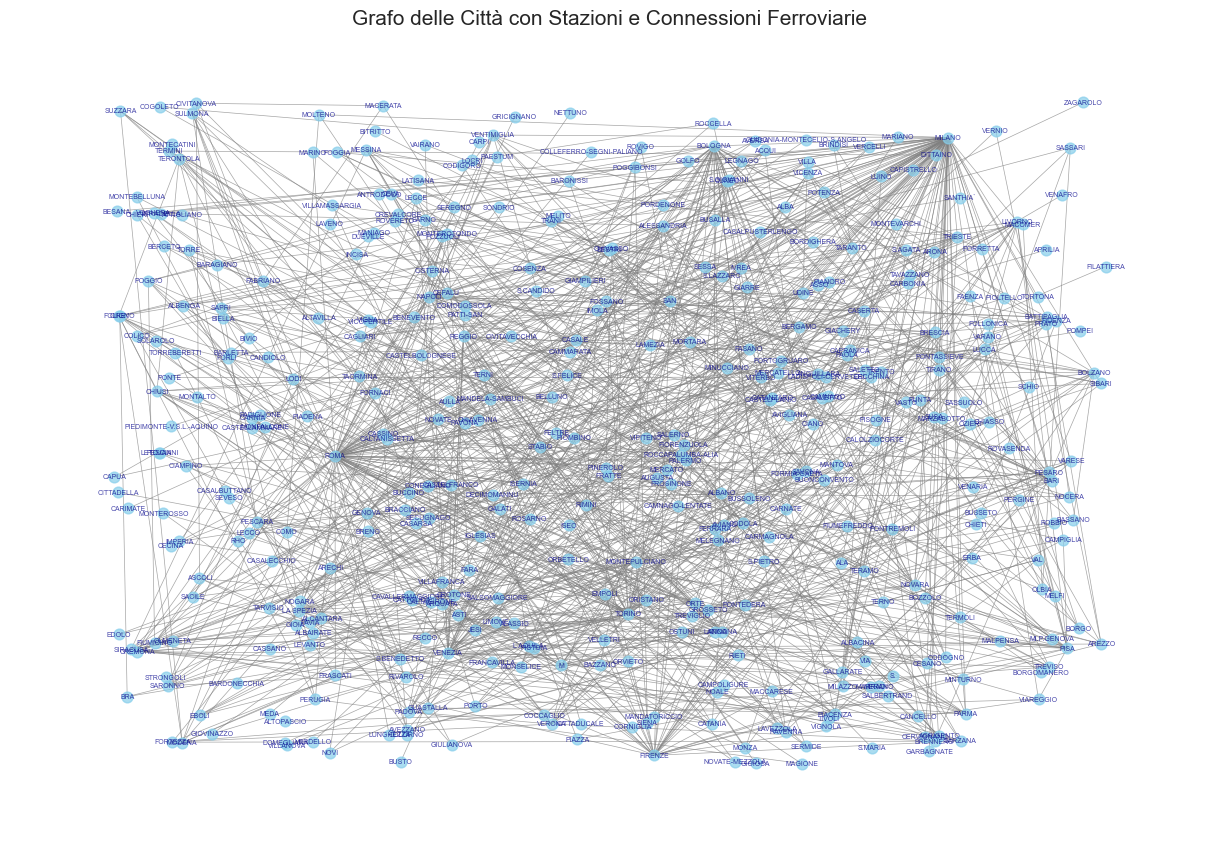

In [98]:
df_citta = pd.read_csv('./dataset/lista_citta_con_stazione.csv')
df_coppie = pd.read_csv('./dataset/treni_solo_citta.csv')

# grafo
G = nx.Graph()

# Mappa per evitare sovrapposizioni
posizioni_usate = {}

for idx, row in df_citta.iterrows():
    # genera posizione casuale non sovrapposta
    while True:
        x = random.uniform(0, 1)  # coordinate x casuali tra 0 e 1
        y = random.uniform(0, 1)  # coordinate y casuali tra 0 e 1
        pos = (x, y)
        if pos not in posizioni_usate.values():
            posizioni_usate[row['citta_uniche']] = pos
            break   
    G.add_node(row['citta_uniche'], pos=pos)

# Aggiunta degli archi (treni da stazPart a stazArr)
for idx, row in df_coppie.iterrows():
    G.add_edge(row['stazPart'], row['stazArr'])

# Rimozione dei cicli
G.remove_edges_from(nx.selfloop_edges(G))

pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(12, 8))
nx.draw(
    G, pos,
    with_labels=True,
    node_color='skyblue',  
    node_size=60,  
    font_size=5,  
    font_color='darkblue',  
    edge_color='gray',  
    width=0.5,  
    alpha=0.7  
)

plt.title('Grafo delle Città con Stazioni e Connessioni Ferroviarie', fontsize=15)
plt.show()

## LAYOUT DEL GRAFO APPENA DESCRITTO

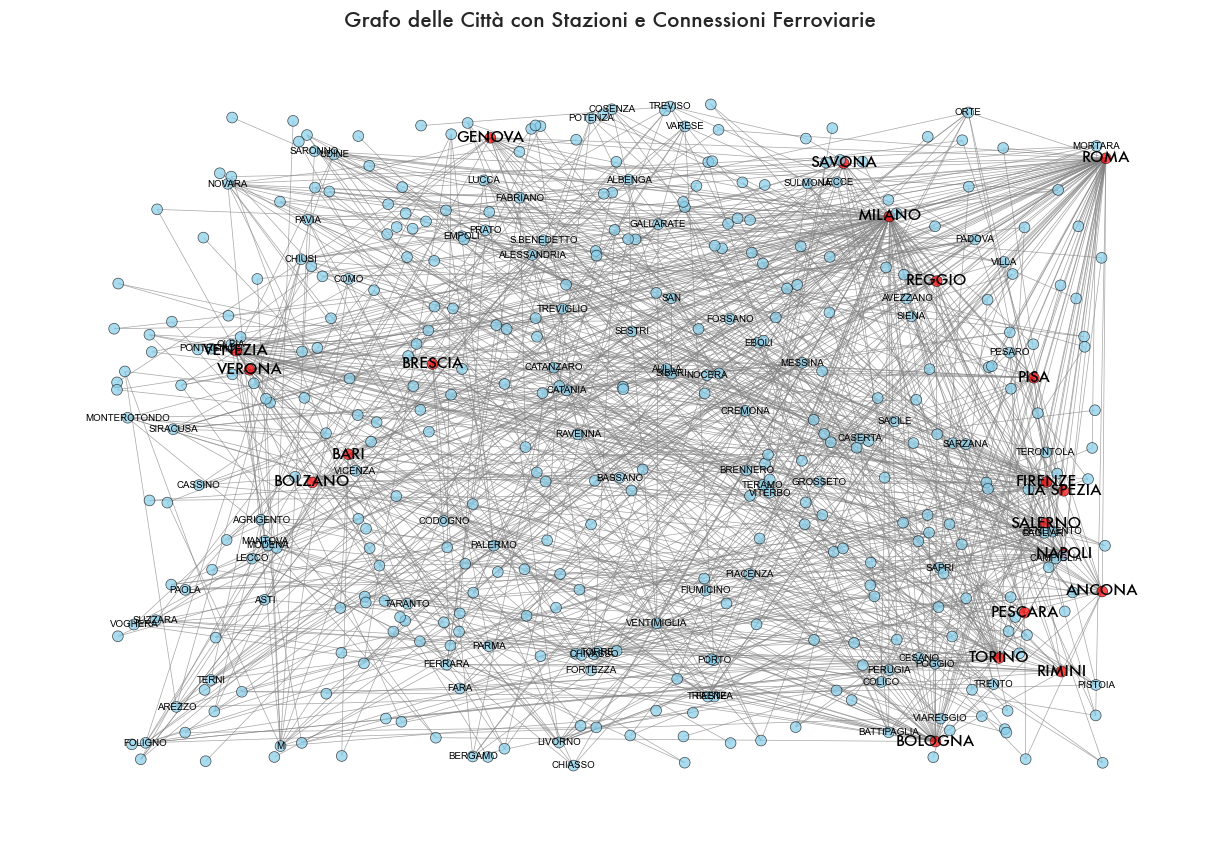

In [99]:
df_citta = pd.read_csv('./dataset/lista_citta_con_stazione.csv')
df_coppie = pd.read_csv('./dataset/treni_solo_citta.csv')

G = nx.Graph()

# Mappa per evitare sovrapposizioni
posizioni_usate = {}

for idx, row in df_citta.iterrows():
    while True:
        x = random.uniform(0, 1)  # Coordinate x casuali tra 0 e 1
        y = random.uniform(0, 1)  # Coordinate y casuali tra 0 e 1
        pos = (x, y)
        if pos not in posizioni_usate.values():
            posizioni_usate[row['citta_uniche']] = pos
            break   
    G.add_node(row['citta_uniche'], pos=pos)

# Aggiunta degli archi (treni da stazPart a stazArr)
for idx, row in df_coppie.iterrows():
    G.add_edge(row['stazPart'], row['stazArr'])

G.remove_edges_from(nx.selfloop_edges(G))  # Rimozione dei cicli

#calcolo la trharshold come la media della degree centrality
degree_centrality = nx.degree_centrality(G)
threshold = np.mean(list(degree_centrality.values()))
# Trovare le città con degree centrality sopra la soglia e prendere i primi 20
significant_cities = {node for node, centrality in degree_centrality.items() if centrality > threshold}
top_20_cities = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:20]

pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(12, 8))
nx.draw(
    G, pos,
    with_labels=False,
    node_color=['red' if node in top_20_cities else 'skyblue' for node in G.nodes()],  # Colore dei nodi
    node_size=60,  
    edge_color='gray',  
    width=0.5,  
    alpha=0.7,  
    edgecolors='black',  
    linewidths=0.5  
)

labels_bold = {node: node for node in top_20_cities}
labels_normal = {node: node for node in G.nodes() if node not in top_20_cities and node in significant_cities}

nx.draw_networkx_labels(G, pos, labels=labels_bold, font_size=11, font_color='black', font_weight='bold', font_family='Futura')
nx.draw_networkx_labels(G, pos, labels=labels_normal, font_size=7, font_color='black', font_weight='normal', font_family='Sans-Serif')
plt.title('Grafo delle Città con Stazioni e Connessioni Ferroviarie', fontsize=15, fontweight='bold', fontname='Futura')
plt.show()


### MISURAZIONI SUL GRAFO

In [100]:
# Calcolo delle misurazioni di centralità e altre metriche
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)
closeness_centrality = nx.closeness_centrality(G)
clustering_coefficient = nx.clustering(G)
density = nx.density(G)

if nx.is_connected(G):
    avg_path_length = nx.average_shortest_path_length(G)
    diameter = nx.diameter(G)
else:
    avg_path_length = None
    diameter = None

connected_components = list(nx.connected_components(G))
connectedness = len(connected_components)

core_number = nx.core_number(G)
assortativity = nx.degree_assortativity_coefficient(G)
bridges = list(nx.bridges(G))

partition = community_louvain.best_partition(G)
modularity = community_louvain.modularity(partition, G)

# Stampa delle metriche
print("Degree Centrality:", degree_centrality)
print("Betweenness Centrality:", betweenness_centrality)
print("Eigenvector Centrality:", eigenvector_centrality)
print("Closeness Centrality:", closeness_centrality)
print("Clustering Coefficient:", clustering_coefficient)
print("Density:", density)
print("Number of Connected Components:", connectedness)
print("Core Numbers:", core_number)
print("Assortativity:", assortativity)
print("Bridges:", bridges)
print("Comunità rilevate:", partition)
print("Modularità:", modularity)

Degree Centrality: {'MONZA': 0.009592326139088728, 'BOLOGNA': 0.09832134292565947, 'FIRENZE': 0.07913669064748201, 'PUNTA': 0.009592326139088728, 'VENEZIA': 0.08393285371702637, 'MILANO': 0.21822541966426856, 'LA SPEZIA': 0.05275779376498801, 'CASERTA': 0.03357314148681055, 'PALERMO': 0.026378896882494004, 'ROMA': 0.18944844124700239, 'NOVATE': 0.009592326139088728, 'CASSINO': 0.01199040767386091, 'BRINDISI': 0.004796163069544364, 'CHIUSI': 0.026378896882494004, 'ANCONA': 0.050359712230215826, 'CALTANISSETTA': 0.007194244604316546, 'BELLUNO': 0.009592326139088728, 'S.BENEDETTO': 0.014388489208633093, 'FOLIGNO': 0.02398081534772182, 'CIVITAVECCHIA': 0.004796163069544364, 'ALESSANDRIA': 0.028776978417266185, 'NOVARA': 0.03357314148681055, 'STABIO': 0.004796163069544364, 'VARESE': 0.016786570743405275, 'FAENZA': 0.01199040767386091, 'PORTOGRUARO': 0.009592326139088728, 'SAVONA': 0.03836930455635491, 'PARMA': 0.026378896882494004, 'TORINO': 0.08872901678657073, 'CIAMPINO': 0.00959232613908

## MAPPA DELL'ITALIA 

In [ ]:
df_citta = pd.read_csv('./dataset/merged_data.csv')
df_coppie = pd.read_csv('./dataset/treni_solo_citta.csv')

# Mappa delle città ai loro set di coordinate
citta_coord = {}
for idx, row in df_citta.iterrows():
    citta_coord[row['citta_uniche']] = (row['LAT'], row['LON'])

# mappa centrata sull'Italia con l'importazione del file .geojson trovato online
m = folium.Map(location=[41.8719, 12.5674], zoom_start=6, zoom_control=False, scrollWheelZoom=False)
geojson_data = './italy.geojson'

# Bordo nero delle regioni
folium.GeoJson(
    geojson_data,
    style_function=lambda feature: {
        'color': 'black',
        'weight': 0.7
    }
).add_to(m)

# aggiungere un arco tra le città di partenza e arrivo
def aggiungi_arco(mappa, citta_partenza, citta_arrivo):
    coord_partenza = citta_coord.get(citta_partenza)
    coord_arrivo = citta_coord.get(citta_arrivo)
    
    if coord_partenza and coord_arrivo:
        folium.PolyLine(
            locations=[coord_partenza, coord_arrivo],
            color='black',
            weight=0.02,
            opacity=1  
        ).add_to(mappa)

# Aggiungi i nodi delle città alla mappa
for idx, row in df_citta.iterrows():
    folium.CircleMarker(
        location=[row['LAT'], row['LON']],
        radius=1,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.5 
    ).add_to(m)

# Aggiungi gli archi tra le città di partenza e arrivo nel DataFrame delle coppie
for idx, row in df_coppie.iterrows():
    aggiungi_arco(m, row['stazPart'], row['stazArr'])

m

# GRAFICI MISURAZIONI

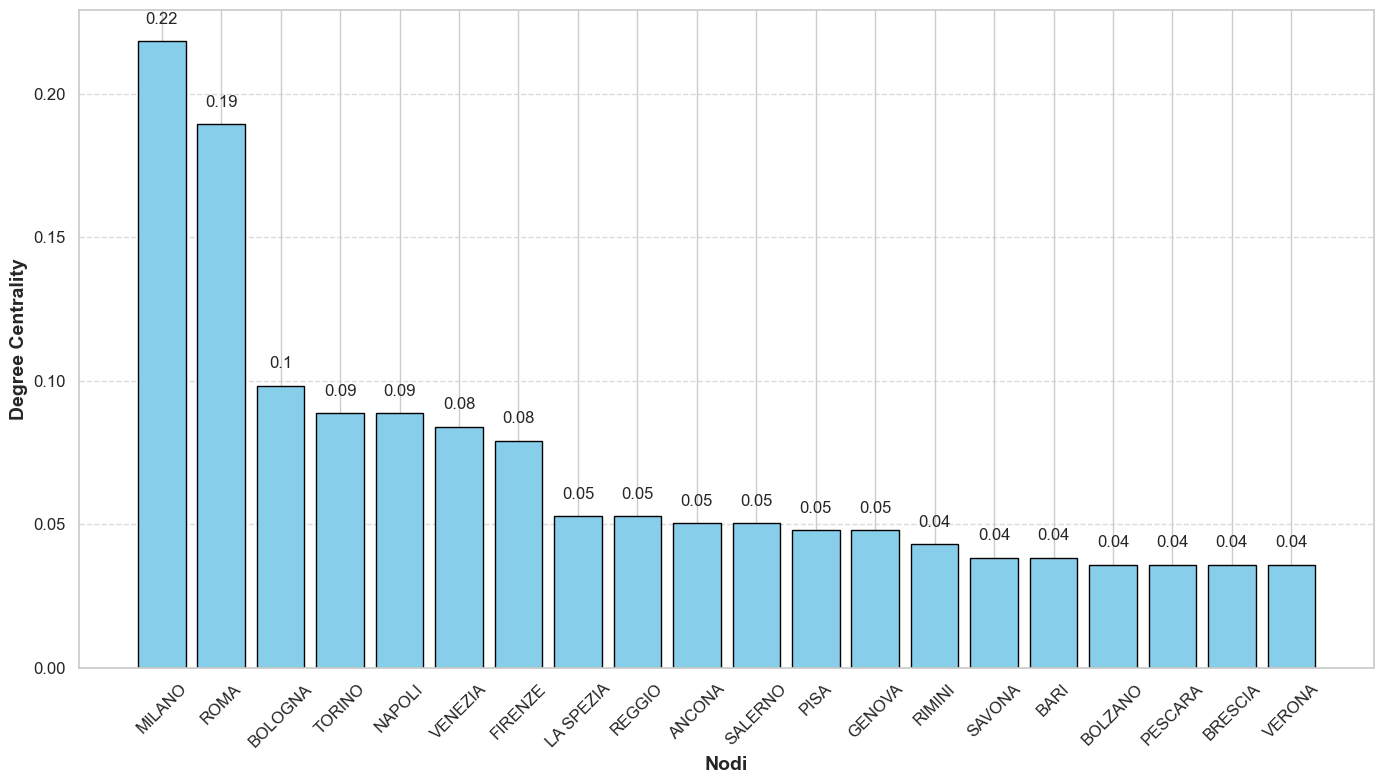

In [102]:
# Ordina i nodi per degree centrality e prendi i primi 10
top_nodes_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:20]
nodes_degree = [node for node, _ in top_nodes_degree]
centrality_values_degree = [value for _, value in top_nodes_degree]

# Plot del grafico a istogramma
plt.figure(figsize=(14, 8))
bars = plt.bar(nodes_degree, centrality_values_degree, color='skyblue', edgecolor='black')
plt.xlabel('Nodi', fontsize=14, fontweight='bold')
plt.ylabel('Degree Centrality', fontsize=14, fontweight='bold')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.005, round(yval, 2), ha='center', va='bottom', fontsize=12)

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

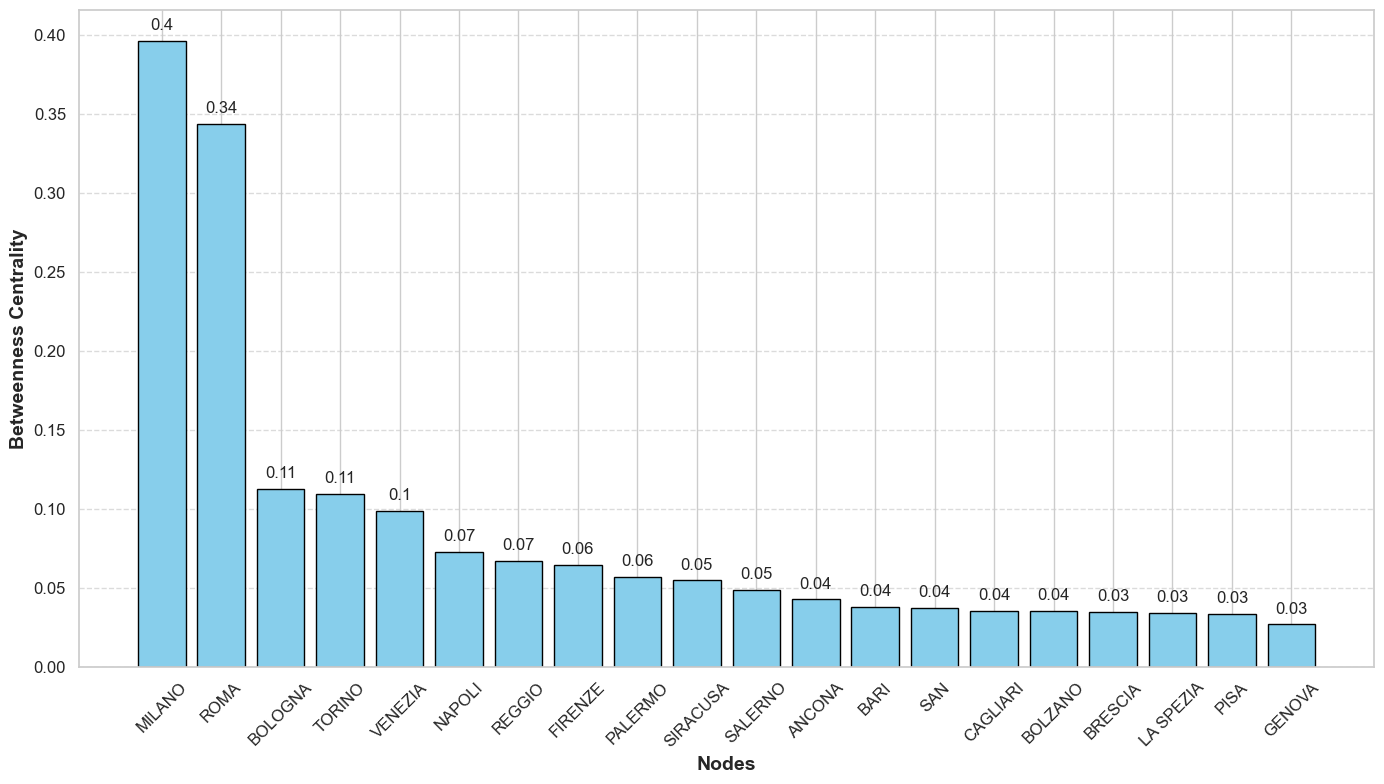

In [103]:
# Ordina i nodi per betweenness centrality e prendi i primi 10
top_nodes_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:20]
nodes_betweenness = [node for node, _ in top_nodes_betweenness]
centrality_values_betweenness = [value for _, value in top_nodes_betweenness]

plt.figure(figsize=(14, 8))
bars = plt.bar(nodes_betweenness, centrality_values_betweenness, color='skyblue', edgecolor='black')
plt.xlabel('Nodes', fontsize=14, fontweight='bold')
plt.ylabel('Betweenness Centrality', fontsize=14, fontweight='bold')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.005, round(yval, 2), ha='center', va='bottom', fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

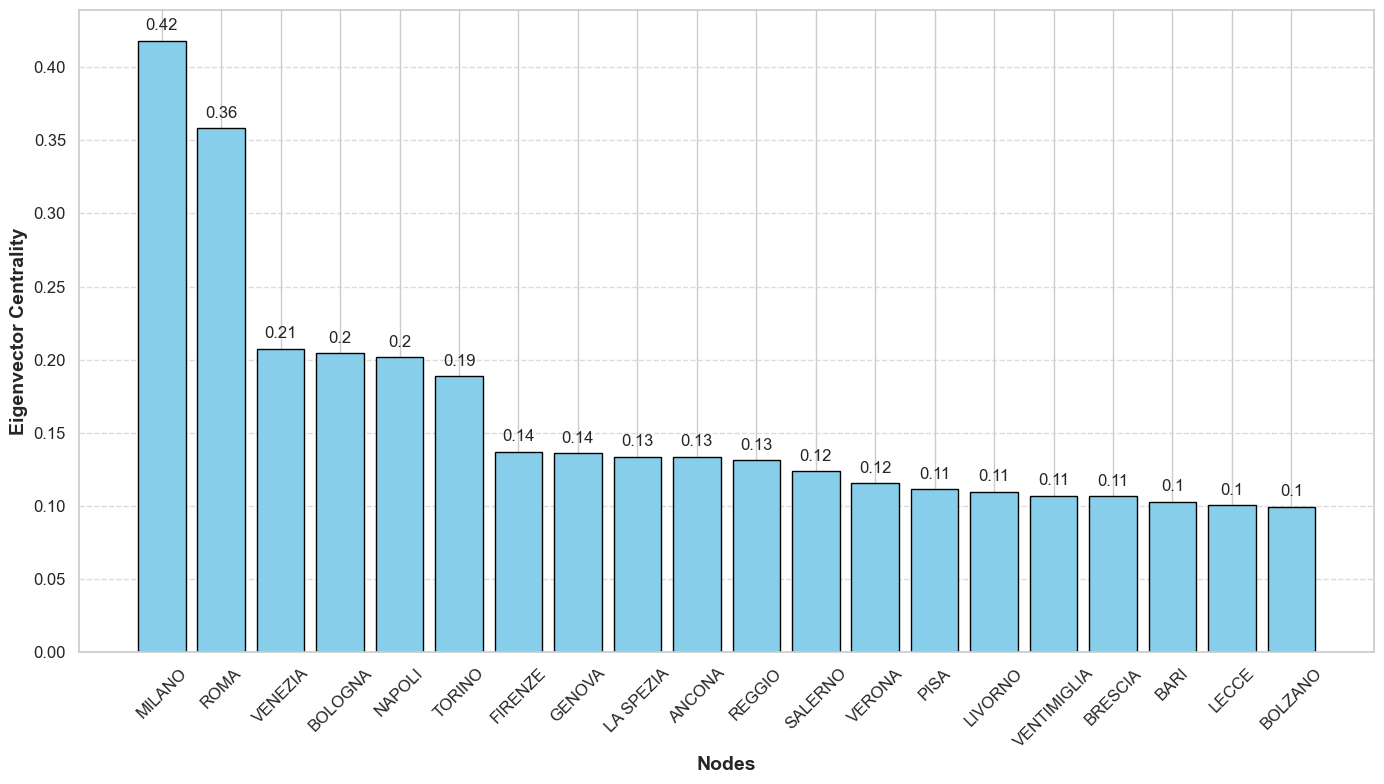

In [104]:
# Ordina i nodi per eigenvector centrality e prendi i primi 10
top_nodes_eigenvector = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:20]
nodes_eigenvector = [node for node, _ in top_nodes_eigenvector]
centrality_values_eigenvector = [value for _, value in top_nodes_eigenvector]

plt.figure(figsize=(14, 8))
bars = plt.bar(nodes_eigenvector, centrality_values_eigenvector, color='skyblue', edgecolor='black')
plt.xlabel('Nodes', fontsize=14, fontweight='bold')
plt.ylabel('Eigenvector Centrality', fontsize=14, fontweight='bold')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.005, round(yval, 2), ha='center', va='bottom', fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

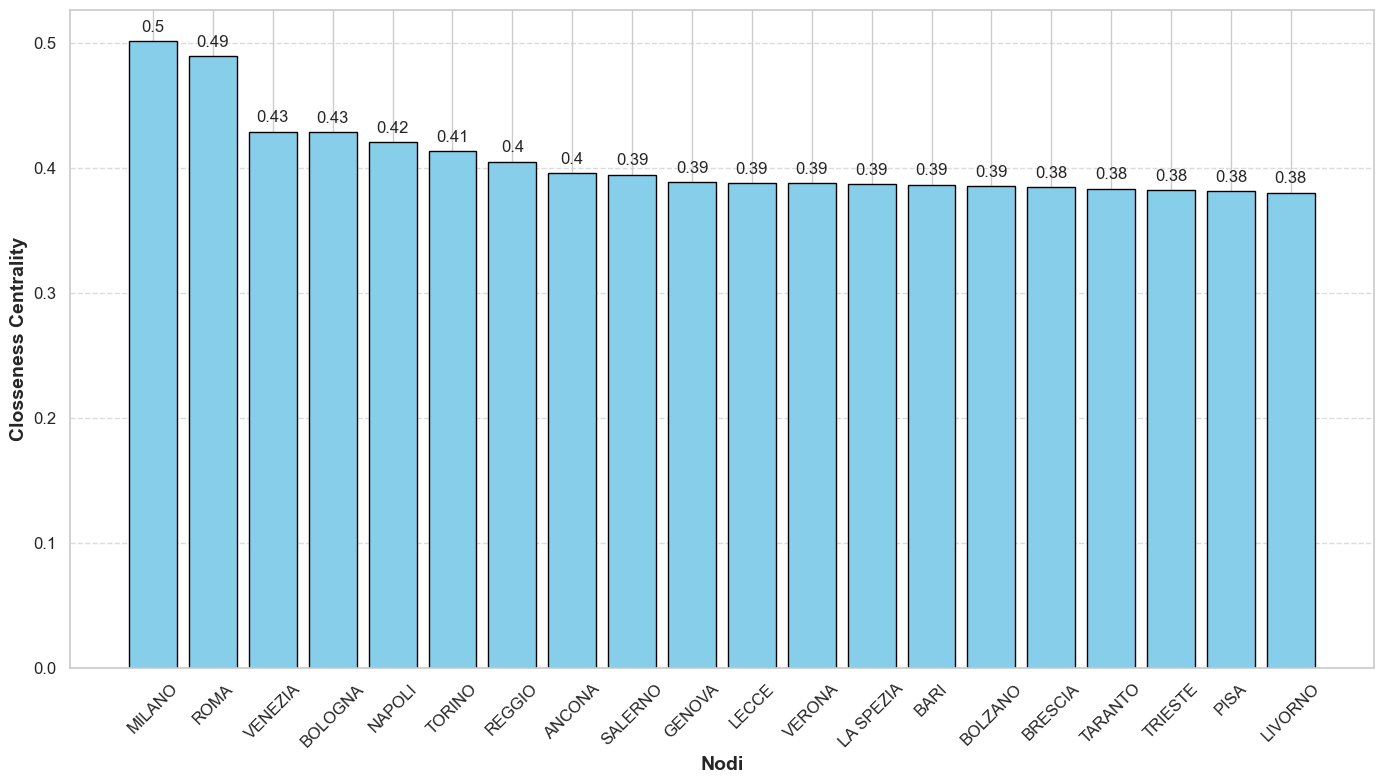

In [105]:
# Ordina i nodi per closeness centrality e prendi i primi 10
top_nodes_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:20]
nodes_closeness = [node for node, _ in top_nodes_closeness]
centrality_values_closeness = [value for _, value in top_nodes_closeness]


plt.figure(figsize=(14, 8))
bars = plt.bar(nodes_closeness, centrality_values_closeness, color='skyblue', edgecolor='black')
plt.xlabel('Nodi', fontsize=14, fontweight='bold')
plt.ylabel('Closseness Centrality', fontsize=14, fontweight='bold')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.005, round(yval, 2), ha='center', va='bottom', fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## CALCOLO DELLE DISTRIBUZIONI DELLE CENTRALITà USANDO LA LEGGE DI POTENZA E LA LEGGE DI POTENZA LOGARITMICA

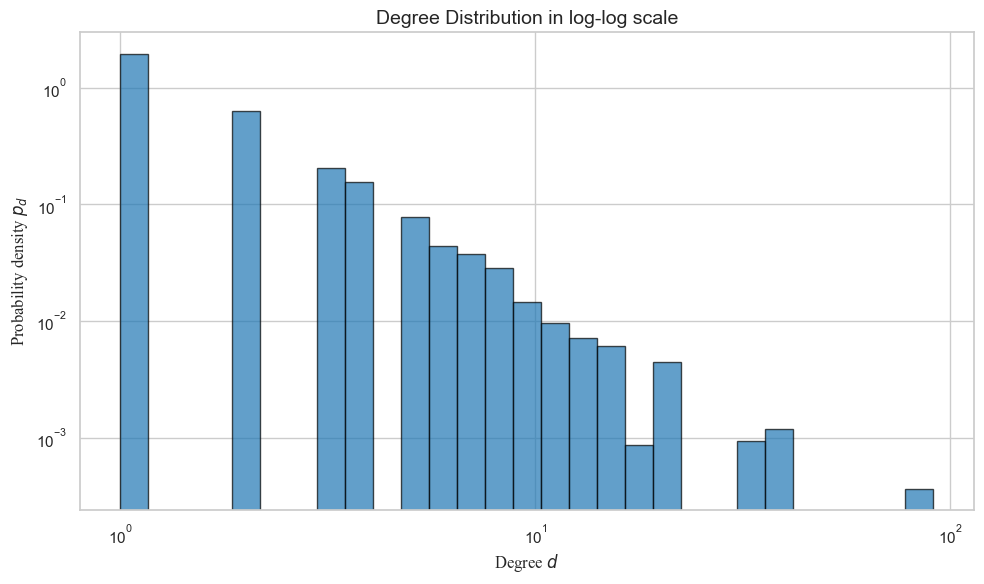

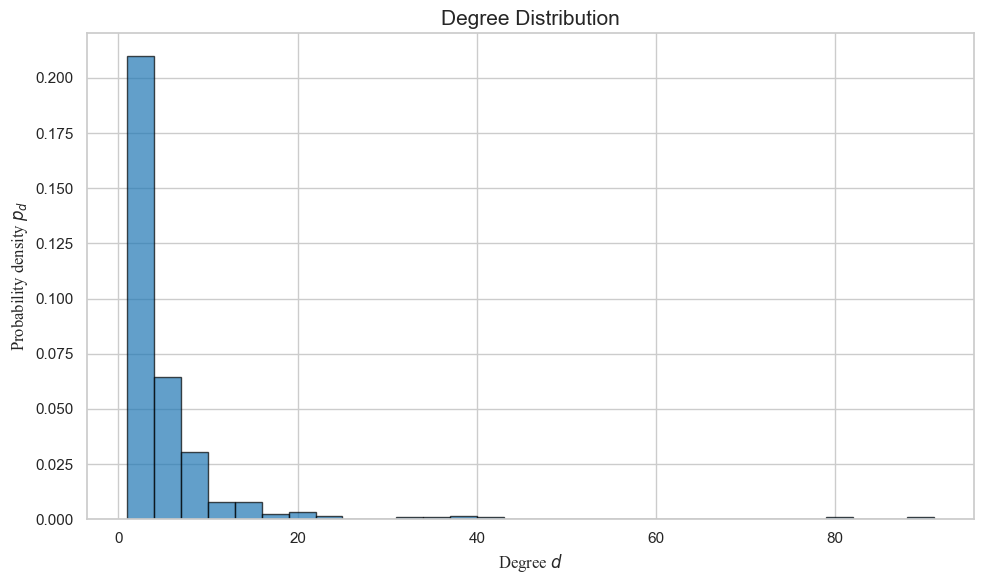

Calculating best minimal value for power law fit
alpha ha valore: 2.972854847071899
pvalue: 0.060112375021881825


In [106]:
# Calcolo dei gradi dei nodi
degree_sequence = [d for n, d in G.degree()]

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Calcolo dell'istogramma in scala log-log
hist, bins, _ = plt.hist(degree_sequence, bins=np.logspace(np.log10(min(degree_sequence)), np.log10(max(degree_sequence)), 30), density=True, alpha=0.7, color='#1f77b4', edgecolor='black')

# Scala logaritmica sull'asse x e y
plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'Degree $d$', fontsize=12, family='Times New Roman')
plt.ylabel(r'Probability density $p_d$', fontsize=12, family='Times New Roman')
plt.title('Degree Distribution in log-log scale', fontsize=14, family='Arial')
plt.tight_layout()


plt.figure(figsize=(10, 6))
# Calcolo dell'istogramma in scala lineare
plt.hist(degree_sequence, bins=30, density=True, alpha=0.7, color='#1f77b4', edgecolor='black')

plt.xlabel(r'Degree $d$', fontsize=12, family='Times New Roman')
plt.ylabel(r'Probability density $p_d$', fontsize=12, family='Times New Roman')
plt.title('Degree Distribution', fontsize=15, family='Arial')
plt.tight_layout()

plt.show()

# Calcolo della power law
fit = powerlaw.Fit(degree_sequence)
alpha = fit.power_law.alpha
pvalue = fit.power_law.D

print(f'alpha ha valore: {alpha}')
print(f'pvalue: {pvalue}')

# SIMULAZIONE E TESTING

In [107]:
lista_parole = ['Roma', 'Milano', 'Bologna', 'Torino', 'Napoli']

df1 = pd.read_csv('./dataset/treni_solo_citta.csv')
# Filtra il DataFrame rimuovendo le righe che contengono almeno una delle parole dalla lista
filtered_df1 = df1[~df1['stazPart'].str.contains('|'.join(lista_parole), case=False, na=False)]
refiltered_df = filtered_df1[~filtered_df1['stazArr'].str.contains('|'.join(lista_parole), case=False, na=False)]
# salva file per fare calcoli delle misurazioni nella sezione che segue
refiltered_df.to_csv('./dataset/simulazione/treni_solo_citta-.csv', index=False)

df2 = pd.read_csv('./dataset/merged_data.csv')
# Filtra il DataFrame rimuovendo le righe che contengono almeno una delle parole dalla lista
filtered_df2 = df2[~df2['citta_uniche'].str.contains('|'.join(lista_parole), case=False, na=False)]
# salva file per fare calcoli delle misurazioni nella sezione che segue
filtered_df2.to_csv('./dataset/simulazione/merged_data-.csv', index=False)


df3 = pd.read_csv('./dataset/lista_citta_con_stazione.csv')
# Filtra il DataFrame rimuovendo le righe che contengono almeno una delle parole dalla lista
filtered_df3 = df3[~df3['citta_uniche'].str.contains('|'.join(lista_parole), case=False, na=False)]
# salva file per fare calcoli delle misurazioni nella sezione che segue
filtered_df3.to_csv('./dataset/simulazione/lista_citta_con_stazione-.csv', index=False)

In [ ]:
df_citta = pd.read_csv('./dataset/simulazione/merged_data-.csv')
df_coppie = pd.read_csv('./dataset/simulazione/treni_solo_citta-.csv')

# Mappa delle città ai loro set di coordinate
citta_coord = {}
for idx, row in df_citta.iterrows():
    citta_coord[row['citta_uniche']] = (row['LAT'], row['LON'])

m = folium.Map(location=[41.8719, 12.5674], zoom_start=6, zoom_control=False, scrollWheelZoom=False)
geojson_data = './italy.geojson'

folium.GeoJson(
    geojson_data,
    style_function=lambda feature: {
        'color': 'black',
        'weight': 0.7
    }
).add_to(m)

# Funzione per aggiungere un arco tra le città di partenza e arrivo
def aggiungi_arco(mappa, citta_partenza, citta_arrivo):
    coord_partenza = citta_coord.get(citta_partenza)
    coord_arrivo = citta_coord.get(citta_arrivo)
    
    if coord_partenza and coord_arrivo:
        folium.PolyLine(
            locations=[coord_partenza, coord_arrivo],
            color='black',
            weight=0.02,
            opacity=1  
        ).add_to(mappa)

for idx, row in df_citta.iterrows():
    folium.CircleMarker(
        location=[row['LAT'], row['LON']],
        radius=1,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7  
    ).add_to(m)

# Aggiungi gli archi 
for idx, row in df_coppie.iterrows():
    aggiungi_arco(m, row['stazPart'], row['stazArr'])

m

In [109]:
df_citta = pd.read_csv('./dataset/simulazione/lista_citta_con_stazione-.csv')
df_coppie = pd.read_csv('./dataset/simulazione/treni_solo_citta-.csv')

# grafo 2
G_2 = nx.Graph()

posizioni_usate = {}

# Aggiungi i nodi (città) al grafo con posizioni casuali non sovrapposte
for idx, row in df_citta.iterrows():
    while True:
        x = random.uniform(0, 1)  # Coordinate x casuali tra 0 e 1
        y = random.uniform(0, 1)  # Coordinate y casuali tra 0 e 1
        pos = (x, y)
        if pos not in posizioni_usate.values():
            posizioni_usate[row['citta_uniche']] = pos
            break
    G_2.add_node(row['citta_uniche'], pos=pos)

# Aggiungi gli archi (connessioni tra città di partenza e arrivo) al grafo
for idx, row in df_coppie.iterrows():
    G_2.add_edge(row['stazPart'], row['stazArr'])

G_2.remove_edges_from(nx.selfloop_edges(G_2))

# Calcolo delle misurazioni di centralità e altre metriche
degree_centrality_2 = nx.degree_centrality(G_2)
betweenness_centrality_2 = nx.betweenness_centrality(G_2)
eigenvector_centrality_2 = nx.eigenvector_centrality(G_2, max_iter=1000)
closeness_centrality_2 = nx.closeness_centrality(G_2)
clustering_coefficient_2 = nx.clustering(G_2)
density_2 = nx.density(G_2)

if nx.is_connected(G_2):
    avg_path_length = nx.average_shortest_path_length(G_2)
    diameter = nx.diameter(G_2)
else:
    avg_path_length = None
    diameter = None

connected_components_2 = list(nx.connected_components(G_2))
connectedness_2 = len(connected_components_2)

core_number_2 = nx.core_number(G_2)
assortativity_2 = nx.degree_assortativity_coefficient(G_2)
bridges_2 = list(nx.bridges(G_2))

# Stampa delle metriche
print("Degree Centrality:", degree_centrality_2)
print("Betweenness Centrality:", betweenness_centrality_2)
print("Eigenvector Centrality:", eigenvector_centrality_2)
print("Closeness Centrality:", closeness_centrality_2)
print("Clustering Coefficient:", clustering_coefficient_2)
print("Density:", density_2)
print("Number of Connected Components:", connectedness_2)
print("Core Numbers:", core_number_2)
print("Assortativity:", assortativity_2)
print("Bridges:", bridges_2)

Degree Centrality: {'MONZA': 0.007281553398058252, 'FIRENZE': 0.07281553398058252, 'PUNTA': 0.009708737864077669, 'VENEZIA': 0.07281553398058252, 'LA SPEZIA': 0.04854368932038834, 'CASERTA': 0.029126213592233007, 'PALERMO': 0.02427184466019417, 'NOVATE': 0.007281553398058252, 'CASSINO': 0.007281553398058252, 'BRINDISI': 0.0048543689320388345, 'CHIUSI': 0.02427184466019417, 'ANCONA': 0.04368932038834951, 'CALTANISSETTA': 0.007281553398058252, 'BELLUNO': 0.009708737864077669, 'S.BENEDETTO': 0.012135922330097085, 'FOLIGNO': 0.021844660194174755, 'CIVITAVECCHIA': 0.0024271844660194173, 'ALESSANDRIA': 0.02669902912621359, 'NOVARA': 0.029126213592233007, 'STABIO': 0.0048543689320388345, 'VARESE': 0.014563106796116504, 'FAENZA': 0.009708737864077669, 'PORTOGRUARO': 0.009708737864077669, 'SAVONA': 0.03398058252427184, 'PARMA': 0.021844660194174755, 'CIAMPINO': 0.007281553398058252, 'PISA': 0.04368932038834951, 'BERGAMO': 0.012135922330097085, 'TREVISO': 0.019417475728155338, 'M': 0.02912621359

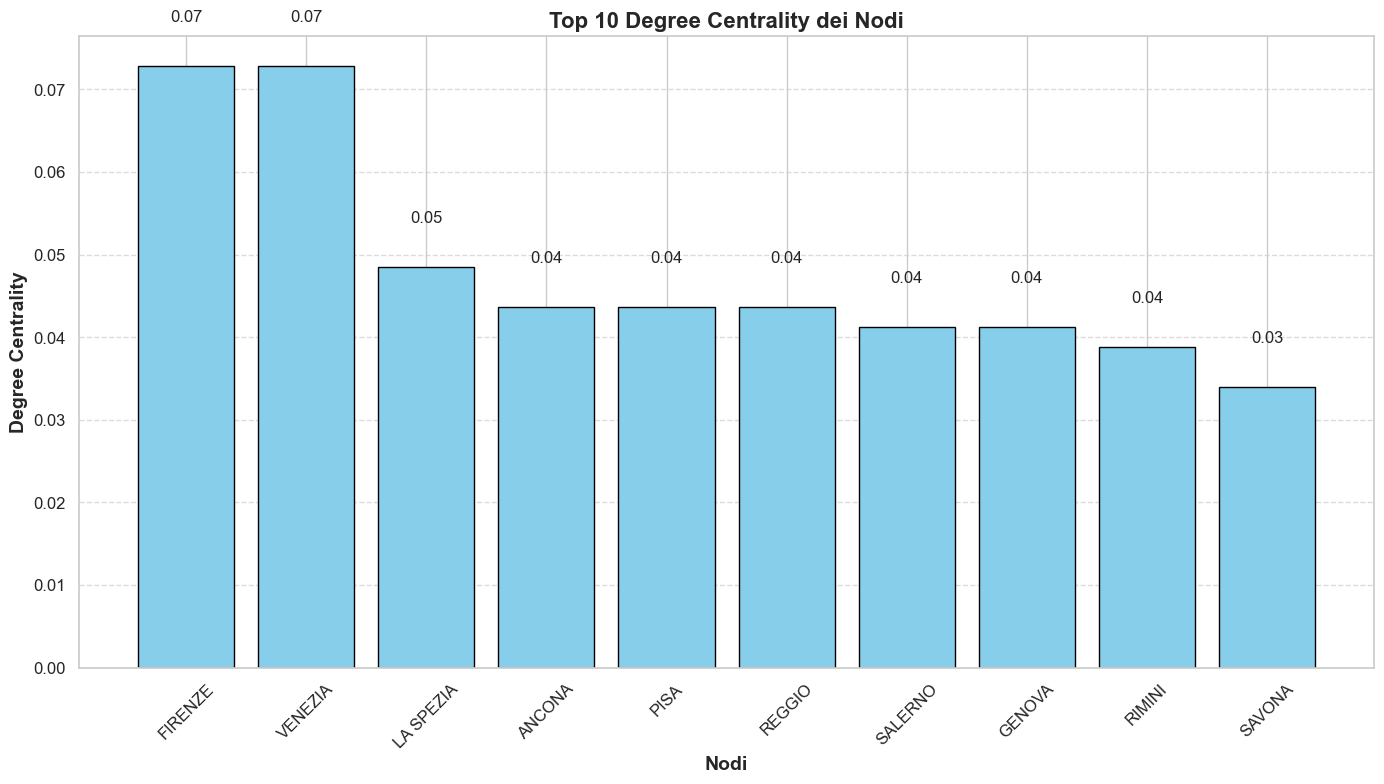

In [110]:
# Ordina i nodi per degree centrality e prendi i primi 10
top_nodes_degree = sorted(degree_centrality_2.items(), key=lambda x: x[1], reverse=True)[:10]
nodes_degree = [node for node, _ in top_nodes_degree]
centrality_values_degree = [value for _, value in top_nodes_degree]

plt.figure(figsize=(14, 8))
bars = plt.bar(nodes_degree, centrality_values_degree, color='skyblue', edgecolor='black')
plt.xlabel('Nodi', fontsize=14, fontweight='bold')
plt.ylabel('Degree Centrality', fontsize=14, fontweight='bold')
plt.title('Top 10 Degree Centrality dei Nodi', fontsize=16, fontweight='bold')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.005, round(yval, 2), ha='center', va='bottom', fontsize=12)

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

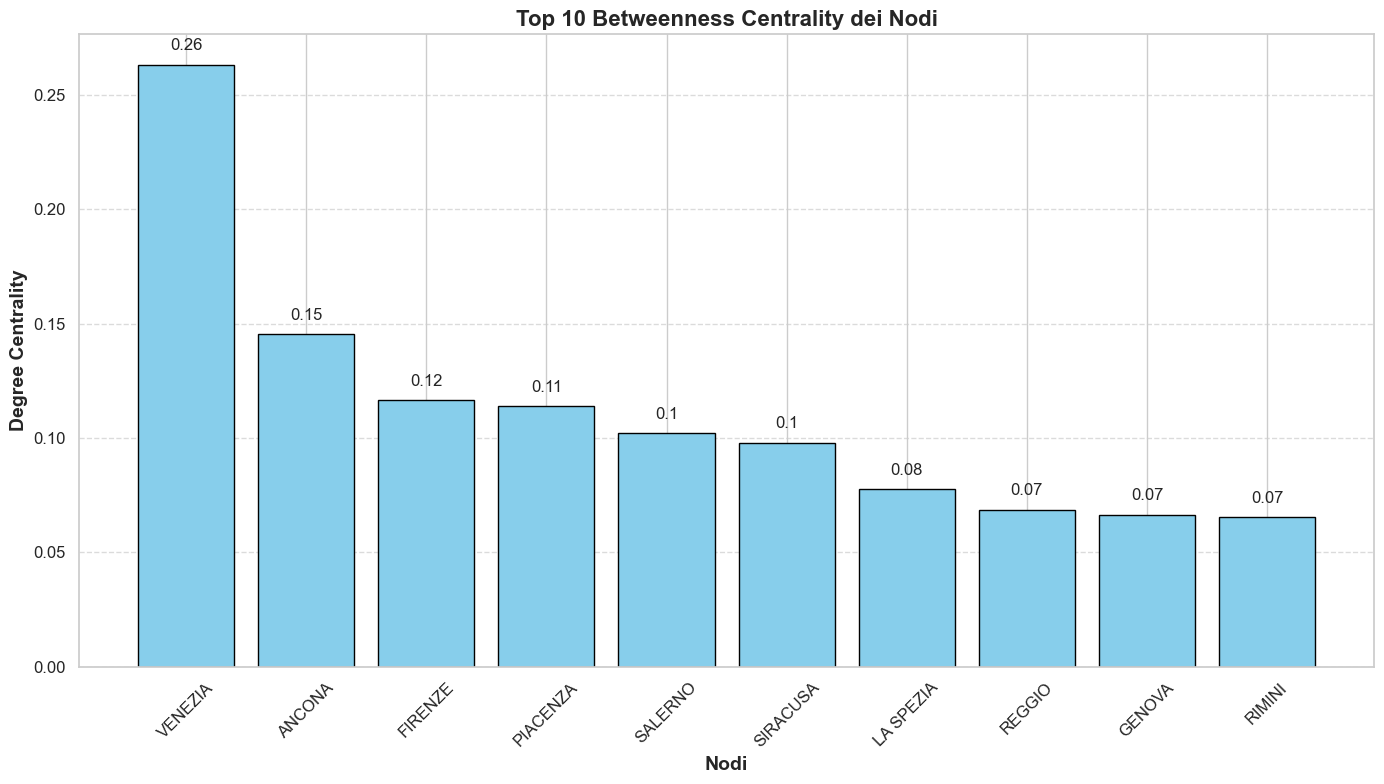

In [111]:
# Ordina i nodi per betweenness centrality e prendi i primi 10
top_nodes_betweenness = sorted(betweenness_centrality_2.items(), key=lambda x: x[1], reverse=True)[:10]
nodes_betweenness = [node for node, _ in top_nodes_betweenness]
centrality_values_betweenness = [value for _, value in top_nodes_betweenness]

plt.figure(figsize=(14, 8))
bars = plt.bar(nodes_betweenness, centrality_values_betweenness, color='skyblue', edgecolor='black')

plt.xlabel('Nodi', fontsize=14, fontweight='bold')
plt.ylabel('Degree Centrality', fontsize=14, fontweight='bold')
plt.title('Top 10 Betweenness Centrality dei Nodi', fontsize=16, fontweight='bold')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.005, round(yval, 2), ha='center', va='bottom', fontsize=12)

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

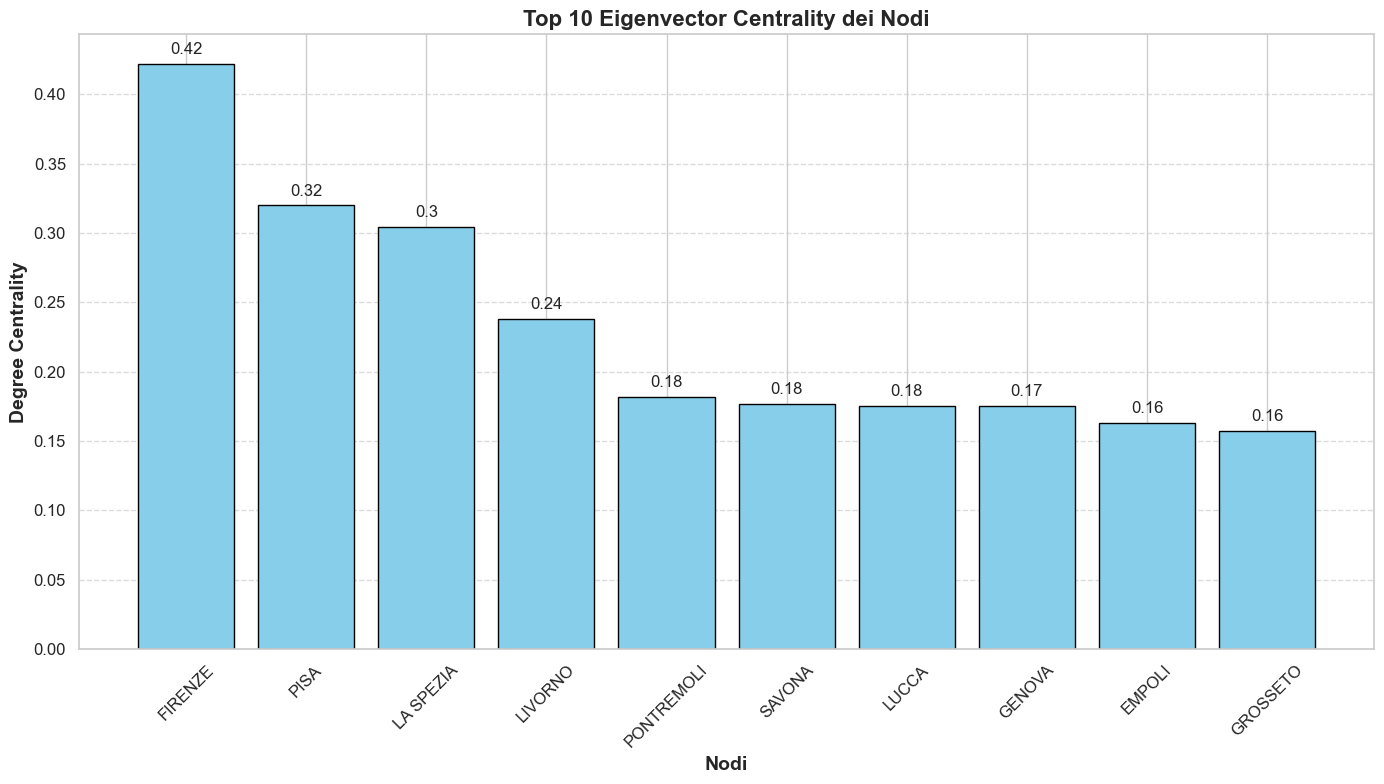

In [112]:
# Ordina i nodi per eigenvector centrality e prendi i primi 10
top_nodes_eigenvector = sorted(eigenvector_centrality_2.items(), key=lambda x: x[1], reverse=True)[:10]
nodes_eigenvector = [node for node, _ in top_nodes_eigenvector]
centrality_values_eigenvector = [value for _, value in top_nodes_eigenvector]

plt.figure(figsize=(14, 8))
bars = plt.bar(nodes_eigenvector, centrality_values_eigenvector, color='skyblue', edgecolor='black')
plt.xlabel('Nodi', fontsize=14, fontweight='bold')
plt.ylabel('Degree Centrality', fontsize=14, fontweight='bold')
plt.title('Top 10 Eigenvector Centrality dei Nodi', fontsize=16, fontweight='bold')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.005, round(yval, 2), ha='center', va='bottom', fontsize=12)

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

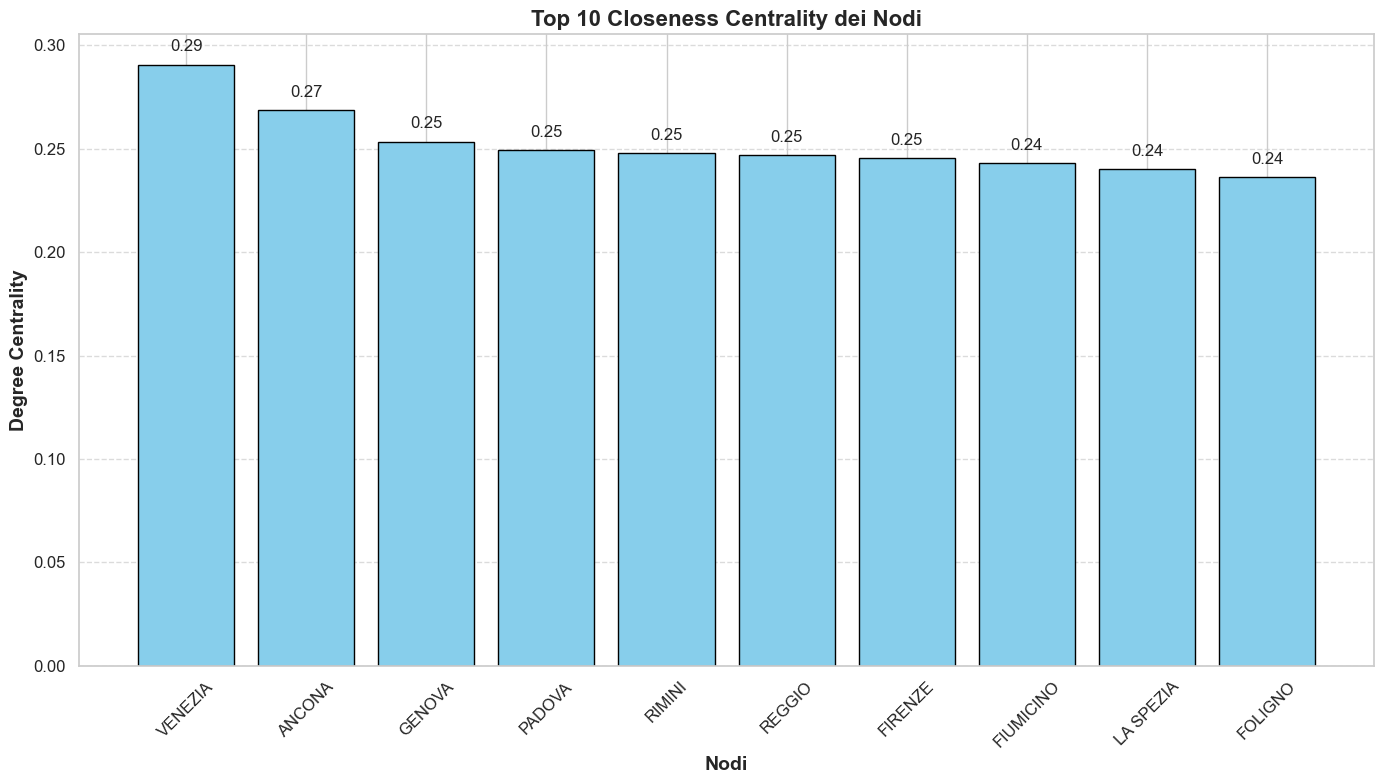

In [113]:
# Ordina i nodi per closeness centrality e prendi i primi 10
top_nodes_closeness = sorted(closeness_centrality_2.items(), key=lambda x: x[1], reverse=True)[:10]
nodes_closeness = [node for node, _ in top_nodes_closeness]
centrality_values_closeness = [value for _, value in top_nodes_closeness]

plt.figure(figsize=(14, 8))
bars = plt.bar(nodes_closeness, centrality_values_closeness, color='skyblue', edgecolor='black')

plt.xlabel('Nodi', fontsize=14, fontweight='bold')
plt.ylabel('Degree Centrality', fontsize=14, fontweight='bold')
plt.title('Top 10 Closeness Centrality dei Nodi', fontsize=16, fontweight='bold')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.005, round(yval, 2), ha='center', va='bottom', fontsize=12)

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

## SIMULAZIONE

In [114]:
# funzione per estrarre 5 città casuali e rimuovere i record corrispondenti
def simulate_network_analysis():
    citta_df = pd.read_csv('./dataset/merged_data.csv')  
    treni_df = pd.read_csv('./dataset/treni_solo_citta.csv')  
    citta_uniche_df = pd.read_csv('./dataset/lista_citta_con_stazione.csv')  

    # estrai 5 città casuali
    citta_casuali = citta_df.sample(n=5)['citta_uniche'].tolist()
    # filtra i treni rimuovendo i record con le città casuali
    treni_filtrati = treni_df[~treni_df['stazPart'].isin(citta_casuali) & ~treni_df['stazArr'].isin(citta_casuali)]
    # filtra le città uniche rimuovendo le città casuali
    citta_uniche_filtrate = citta_uniche_df[~citta_uniche_df['citta_uniche'].isin(citta_casuali)]

    G = nx.DiGraph()
    for _, row in treni_filtrati.iterrows():
        G.add_edge(row['stazPart'], row['stazArr'])

    density = nx.density(G)
    components = nx.number_connected_components(G.to_undirected())

    return density, components

# esegui la simulazione 100 volte e calcola la media delle misurazioni
densities = []
components = []

for _ in range(100):
    density, component = simulate_network_analysis()
    densities.append(density)
    components.append(component)

avg_density = sum(densities) / len(densities)
avg_components = sum(components) / len(components)

print(f"Media Density: {avg_density}")
print(f"Media Connected Components: {avg_components}")

Media Density: 0.009499834970003215
Media Connected Components: 1.15
